In [134]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [135]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot
from sklearn.model_selection import train_test_split

import seaborn as sns
import tensorflow
print(tensorflow.__version__)


from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import os

2.12.0


In [136]:
# display all dataframe columns
pd.options.display.max_columns = None

# to set the limit to 3 decimals
pd.options.display.float_format = '{:.7f}'.format

# display all dataframe rows
pd.options.display.max_rows = None

In [137]:
# Data source - "https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset"

df = pd.read_csv('/content/drive/MyDrive/Internship/spam.csv', encoding= 'latin-1')

In [138]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [139]:
pd.value_counts(df['v1'])

ham     4825
spam     747
Name: v1, dtype: int64

<Axes: >

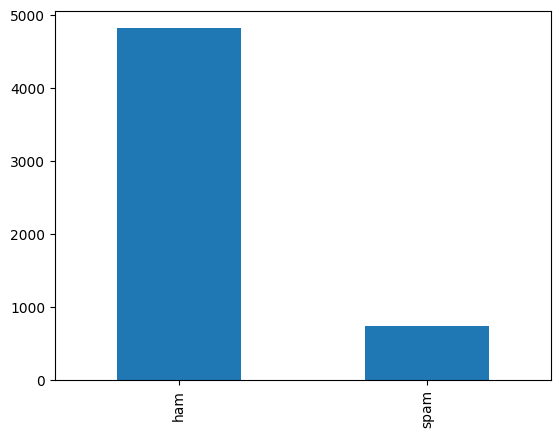

In [140]:
pd.value_counts(df['v1']).plot(kind = 'bar')

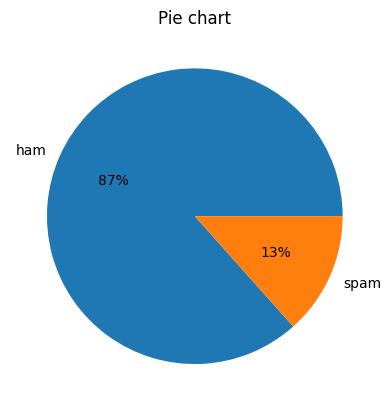

In [141]:
df['v1'].value_counts().plot(kind = 'pie',  autopct='%1.0f%%')
plt.title('Pie chart')
plt.ylabel('')
plt.show()

In [142]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [143]:
df['v1'].replace('ham',0, inplace = True)
df['v1'].replace('spam',1, inplace = True)

In [144]:
df.rename(columns={"v1":"Label","v2":"Message"},inplace=True)

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Label    5572 non-null   int64 
 1   Message  5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [146]:
# Text Preprocessing

df['message_len'] = df['Message'].apply(len)
df.head()

,Label,Message,message_len
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


<Axes: xlabel='message_len', ylabel='Density'>

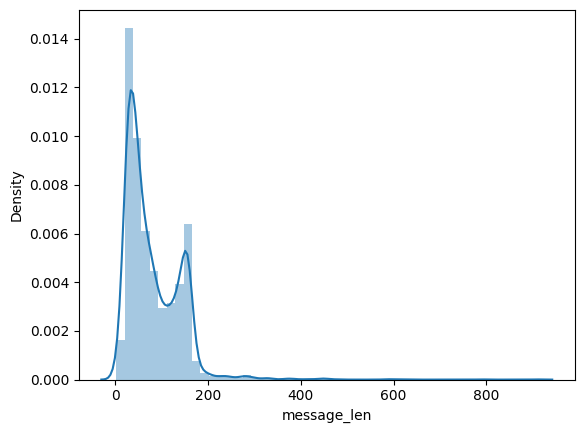

In [147]:
sns.distplot(df['message_len'])

<Axes: xlabel='message_len'>

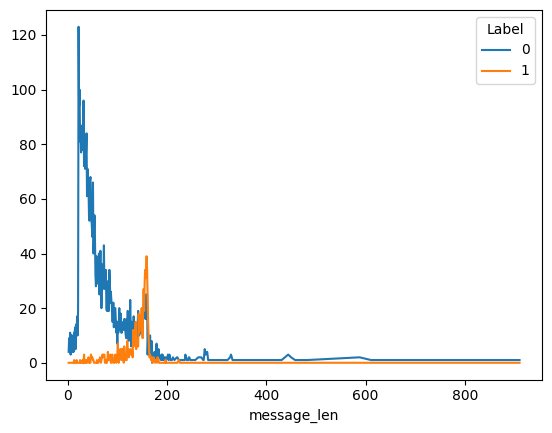

In [148]:
pd.crosstab(df['message_len'],df['Label']).plot()

In [149]:
df.describe()

,Label,message_len
count,5572.0000000,5572.0000000
mean,0.1340632,80.1188083
std,0.3407508,59.6908408
min,0.0000000,2.0000000
25%,0.0000000,36.0000000
50%,0.0000000,61.0000000
75%,0.0000000,121.0000000
max,1.0000000,910.0000000


In [150]:
# Convert to lower case
df['text'] = df['Message'].apply(lambda x: x.lower())

In [151]:
# Removing stop words

from nltk.corpus import stopwords
import string
import nltk

nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [152]:
df['text'] = df['text'].apply(lambda words: ' '.join(word for word in words.split() if word not in stop))

In [153]:
# Remove punctuations

df['text'] = df['text'].str.replace('[^\w\s]','')

In [154]:
df.head(2)

,Label,Message,message_len,text
0,0,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,29,ok lar joking wif u oni


In [155]:
X = df['text']
y = df['Label']

In [156]:
# Model building

# LSTM Model

In [157]:
# Splitting the data into train and test set using default size

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df['text'],y,test_size=0.25)

In [158]:
max_words = 1000
max_len = 100

In [159]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import pad_sequences

In [160]:
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

In [161]:
# Define model

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten


def rnn_model():

# Create model

    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='Features')(layer)
    layer = Activation('relu')(layer)
    layer = Dense(1,name='Out')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [162]:
# Build the model

model = rnn_model()

In [163]:
# Compile model

model.summary()
model.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy']) # Loss function = binary cross entropy

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 100)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 100, 50)           50000     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 Features (Dense)            (None, 256)               16640     
                                                                 
 activation_2 (Activation)   (None, 256)               0         
                                                                 
 Out (Dense)                 (None, 1)                 257       
                                                                 
 activation_3 (Activation)   (None, 1)                 0   

In [164]:
# Fit the model

training_history = model.fit(sequences_matrix,y_train,batch_size=32,epochs=20,
          validation_split=0.2)

Epoch 1/20
105/105 [==============================] - 11s 76ms/step - loss: 0.2510 - accuracy: 0.9127 - val_loss: 0.0761 - val_accuracy: 0.9749
Epoch 2/20
105/105 [==============================] - 10s 97ms/step - loss: 0.0599 - accuracy: 0.9815 - val_loss: 0.0513 - val_accuracy: 0.9797
Epoch 3/20
105/105 [==============================] - 10s 92ms/step - loss: 0.0329 - accuracy: 0.9901 - val_loss: 0.0541 - val_accuracy: 0.9797
Epoch 4/20
105/105 [==============================] - 11s 103ms/step - loss: 0.0232 - accuracy: 0.9928 - val_loss: 0.0616 - val_accuracy: 0.9797
Epoch 5/20
105/105 [==============================] - 9s 88ms/step - loss: 0.0157 - accuracy: 0.9955 - val_loss: 0.0693 - val_accuracy: 0.9833
Epoch 6/20
105/105 [==============================] - 7s 70ms/step - loss: 0.0119 - accuracy: 0.9976 - val_loss: 0.0804 - val_accuracy: 0.9809
Epoch 7/20
105/105 [==============================] - 12s 115ms/step - loss: 0.0095 - accuracy: 0.9976 - val_loss: 0.0728 - val_accuracy:

In [165]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

per = model.evaluate(test_sequences_matrix,y_test)

44/44 [==============================] - 1s 18ms/step - loss: 0.1354 - accuracy: 0.9792


In [166]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(per[0],per[1]))

Test set
  Loss: 0.135
  Accuracy: 0.979


# Naive Bayes Model

In [167]:
# Splitting the data into train and test set using default size

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df['text'],y,test_size=0.25)

In [168]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer

vectorizer = CountVectorizer()
vectorizer.fit(X_train)

CountVectorizer()

In [169]:
# Learn training data vocabulary, then use it to create a document-term matrix

X_train_transformed = vectorizer.transform(X_train)

In [170]:
X_test_transformed = vectorizer.transform(X_test)

In [171]:
# Import and instantiate a Multinomial Naive Bayes model

from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

In [172]:
nb.fit(X_train_transformed, y_train)

MultinomialNB()

In [173]:
# make class predictions for X_test

y_pred_class = nb.predict(X_test_transformed)

In [174]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
metrics.accuracy_score(y_train, nb.predict(X_train_transformed))

0.9935391241923905

In [175]:
# calculate accuracy of class predictions

from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.9842067480258435

In [176]:
# print the confusion matrix

metrics.confusion_matrix(y_test, y_pred_class)

array([[1183,    6],
       [  16,  188]])

In [177]:
# Both LSTM and Naive Bayes are able to perfrom very well on this data.
# We are able to get aprox. 98% accuracy with Naive Bayes